### Imports 🛂

In [1]:
# Add root project folder to path
import sys
sys.path.append('../')

# Dependencies
import numpy as np
from datetime import datetime
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

# Components
from unet.dataset import ShapesDataset
from unet.unet import UNet

### Define some of the training parameters 🏋

In [2]:
TRAIN_NUM_EXAMPLES = 50
IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS = 256, 256, 3
NUM_EPOCHS = 1
BATCH_SIZE = 1

### Create the synthetic shape dataset 🧪
Dataset module thanks to [Mask-RCNN](https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb) by Matterport

In [3]:
dataset_train = ShapesDataset()
dataset_train.load_shapes(TRAIN_NUM_EXAMPLES, IMAGE_HEIGHT, IMAGE_WIDTH)
dataset_train.prepare()

### Organize the dataset into two numpy arrays ✈ 
And treshold the segmentation masks to get an alpha image

In [4]:
image = [dataset_train.load_image(image_id).astype(
    np.float32) / 255 for image_id in dataset_train.image_ids]
masks = []
for image_id in dataset_train.image_ids:
    mask, classes = dataset_train.load_mask(image_id)

    # Treshold the segmentation images to get b&w alpha mask
    mask_treshold = np.expand_dims(
        np.where(mask[:, :, 0] > 0, 255, 0).astype(np.float32),
        axis=3) / 255
    masks.append(mask_treshold)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  # Remove the CWD from sys.path while we load stuff.


### Plot a sample from the dataset 📊

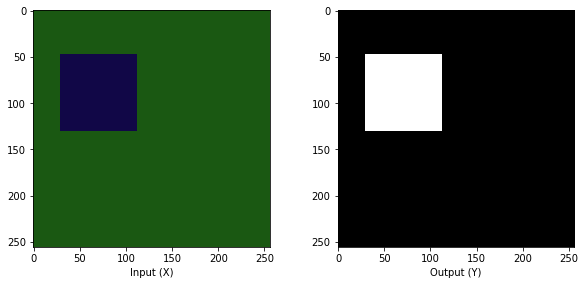

In [5]:
fig=plt.figure(figsize=(20, 20))

random_selector = np.random.randint(len(dataset_train.image_ids))

fig.add_subplot(4, 1, 1)
plt.imshow(image[random_selector])
plt.xlabel("Input (X)")

fig.add_subplot(4, 2, 2)
plt.imshow(masks[random_selector][:,:,0], cmap='gray')
plt.xlabel("Output (Y)")

plt.show()

### Create the U-network model instance and print the summary

In [6]:
unet = UNet()
unet.compile(optimizer="adam",
             loss="binary_crossentropy",
             metrics=["accuracy"])
unet.build((None, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
unet.summary()

Model: "Unet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1792      
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  73856     
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_4 (Conv2D)            multiple                  295168 

### Small utility class to plot training accuracy the Keras way 🛠

In [7]:
class PlotCallbacks(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.accs = []
        self.acc_avg = []

    def on_batch_end(self, batch, logs={}):
        self.accs.append(round(1e2*float(logs.get('accuracy')),4))
        self.acc_avg.append(round(np.mean(self.accs,dtype=np.float64),4))
    
    def on_train_end(self, logs={}):
        plt.plot(self.acc_avg)
        plt.xlabel("Batch")
        plt.ylabel("Accuracy")
        plt.show()

# Train 👟

Train on 50 samples
50/50 [==============================] - 227s 5s/sample - loss: 129.7377 - accuracy: 0.9313


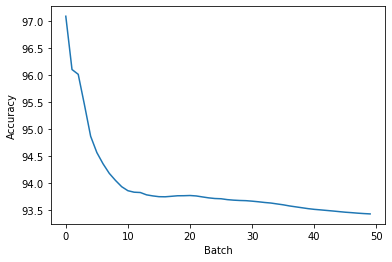

In [8]:
history = unet.fit(np.array(image),  # X
                   np.array(masks),  # Y
                   batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS,
                   callbacks=[PlotCallbacks()],
                   verbose=1)